date: 2022-04-24 11:17:17
author: Jerry Su
slug:  Image-Tilt-Correction
title: Image tilt correction
category:
tags: CV
summary: Reason is the light and the light of life.
toc: show

In [21]:
from matplotlib import pyplot as plt
import cv2
import numpy as np
import math

/tmp/ipykernel_18659/3636876388.py:33: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.title(name, fontSize =16, color="b")


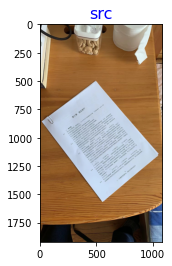

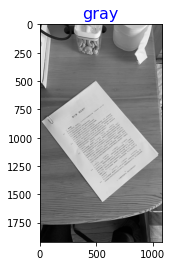

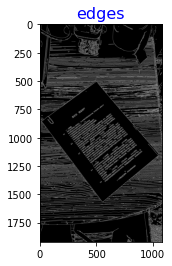

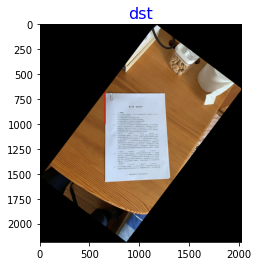

In [35]:
def rotate_image(mat, angle):
    """
    Rotates an image (angle in degrees) and expands image to avoid cropping
    """
    height, width = mat.shape[:2]  # image shape has 3 dimensions
    image_center = (width / 2, height / 2)  # getRotationMatrix2D needs coordinates in reverse order (width, height) compared to shape

    rotation_mat = cv2.getRotationMatrix2D(image_center, angle, 1.)

    # rotation calculates the cos and sin, taking absolutes of those.
    abs_cos = abs(rotation_mat[0, 0])
    abs_sin = abs(rotation_mat[0, 1])

    # find the new width and height bounds
    bound_w = int(height * abs_sin + width * abs_cos)
    bound_h = int(height * abs_cos + width * abs_sin)

    # subtract old image center (bringing image back to origo) and adding the new image center coordinates
    rotation_mat[0, 2] += bound_w / 2 - image_center[0]
    rotation_mat[1, 2] += bound_h / 2 - image_center[1]

    # rotate image with the new bounds and translated rotation matrix
    new_image = cv2.warpAffine(mat, rotation_mat, (bound_w, bound_h))  # , borderValue=(155,255,255))

    return new_image


def show_img(name, img):
    plt.subplot(1,1,1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(name, fontSize =16, color="b")
    plt.show()


def correct_image(cv2_image):
    gray = cv2.cvtColor(cv2_image, cv2.COLOR_BGR2GRAY)
    show_img("gray", gray)
    # gray = cv2.GaussianBlur(gray, (9, 9), 9)  # 高斯滤波
    # ret, gray = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
    edges = cv2.Canny(gray, 50, 150, apertureSize=3)    # 边缘检测
    show_img("edges", edges)
    threshold = 1000    # 阈值化
    lines = cv2.HoughLines(image=edges, rho=1, theta=np.pi / 180, threshold=threshold)
    while lines is None:
        if threshold <= 0:
            return cv2_image    # 未检测到任意直线，不矫正返回原图
        threshold -= 50
        lines = cv2.HoughLines(image=edges, rho=1, theta=np.pi / 180, threshold=threshold)
    rotate_angle = 0
    for rho, theta in lines[0]:
        a, b = np.cos(theta), np.sin(theta)
        x0, y0 = a * rho, b * rho
        x1, y1 = int(x0 + 1000 * (-b)), int(y0 + 1000 * (a))
        x2, y2 = int(x0 - 1000 * (-b)), int(y0 - 1000 * (a))
        cv2.line(img=cv2_image, pt1=(x1, y1), pt2=(x2, y2), color=(0, 0, 255), thickness=10)
        if x1 == x2 or y1 == y2:
            continue
        k = float(y2 - y1) / (x2 - x1)
        # math.atan弧度在[-PI/2 : PI/2]，即-90度到90度
        rotate_angle = math.degrees(math.atan(k))
        # 旋转角度全部映射到-45度到45度之间
        if rotate_angle > 45:
            rotate_angle = -90 + rotate_angle
        elif rotate_angle < -45:
            rotate_angle = 90 + rotate_angle
    # print("rotate_angle : " + str(rotate_angle))
    # 按照totate_angle角度旋转图片
    image_rotated = rotate_image(cv2_image, rotate_angle)
    return image_rotated

    
img = cv2.imread("test.jpeg")
show_img("src", img)
image_rotated = correct_image(img)
show_img("dst", image_rotated)